In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from scipy.stats import expon, gamma, lognorm, weibull_min, beta, chi2, rayleigh, pareto, f, cauchy
import platform
from matplotlib.animation import FuncAnimation
import warnings

# Matplotlibのフォント警告を抑制
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# システムに応じたフォントを選択
def get_available_font():
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    system = platform.system()
    if system == "Windows":
        for font in ['MS Gothic', 'Yu Gothic', 'Meiryo']:
            if font in available_fonts:
                return font
    elif system == "Darwin":  # Mac
        for font in ['Hiragino Sans', 'AppleGothic', 'Noto Sans CJK JP']:
            if font in available_fonts:
                return font
    elif system == "Linux":
        for font in ['Noto Sans CJK JP', 'DejaVu Sans']:
            if font in available_fonts:
                return font
    return 'DejaVu Sans'

# フォントを設定
selected_font = get_available_font()
plt.rcParams['font.family'] = selected_font
print(f"Selected font: {selected_font}")

# 分布のリスト（名前、パラメータ、期待値、x範囲、a範囲）
distributions = [
    {
        'name': 'exponential',
        'params': {'scale': 1},  # E[X] = scale = 1
        'mu': 1,
        'x_range': (0, 10),
        'a_range': (1, 4),
        'pdf_func': lambda x, params: expon.pdf(x, scale=params['scale']),
        'cdf_func': lambda a, params: expon.cdf(a, scale=params['scale']),
        'dist_label': '指数分布 (λ=1)'
    },
    {
        'name': 'gamma',
        'params': {'k': 2, 'theta': 1},  # E[X] = k*theta = 2
        'mu': 2,
        'x_range': (0, 10),
        'a_range': (1, 4),
        'pdf_func': lambda x, params: gamma.pdf(x, a=params['k'], scale=params['theta']),
        'cdf_func': lambda a, params: gamma.cdf(a, a=params['k'], scale=params['theta']),
        'dist_label': 'ガンマ分布 (k=2, θ=1)'
    },
    {
        'name': 'lognorm',
        'params': {'mu': 0, 'sigma': 0.5},  # E[X] = exp(mu + sigma^2/2) ≈ 1.284
        'mu': np.exp(0 + 0.5**2 / 2),
        'x_range': (0, 10),
        'a_range': (1, 4),
        'pdf_func': lambda x, params: lognorm.pdf(x, s=params['sigma'], scale=np.exp(params['mu'])),
        'cdf_func': lambda a, params: lognorm.cdf(a, s=params['sigma'], scale=np.exp(params['mu'])),
        'dist_label': '対数正規分布 (μ=0, σ=0.5)'
    },
    # {
    #     'name': 'weibull',
    #     'params': {'c': 2, 'scale': 1.128},  # E[X] = scale * Γ(1 + 1/c) ≈ 1
    #     'mu': 1.128 * gamma(1 + 1/2),
    #     'x_range': (0, 10),
    #     'a_range': (1, 4),
    #     'pdf_func': lambda x, params: weibull_min.pdf(x, c=params['c'], scale=params['scale']),
    #     'cdf_func': lambda a, params: weibull_min.cdf(a, c=params['c'], scale=params['scale']),
    #     'dist_label': 'ワイブル分布 (c=2, scale=1.128)'
    # },
    {
        'name': 'beta',
        'params': {'a': 2, 'b': 3},  # E[X] = a/(a+b) = 0.4
        'mu': 2 / (2 + 3),
        'x_range': (0, 1),  # ベータは[0,1]に限定
        'a_range': (0.1, 0.8),
        'pdf_func': lambda x, params: beta.pdf(x, a=params['a'], b=params['b']),
        'cdf_func': lambda a, params: beta.cdf(a, a=params['a'], b=params['b']),
        'dist_label': 'ベータ分布 (α=2, β=3)'
    },
    {
        'name': 'chi2',
        'params': {'df': 2},  # E[X] = df = 2
        'mu': 2,
        'x_range': (0, 10),
        'a_range': (1, 4),
        'pdf_func': lambda x, params: chi2.pdf(x, df=params['df']),
        'cdf_func': lambda a, params: chi2.cdf(a, df=params['df']),
        'dist_label': 'カイ二乗分布 (df=2)'
    },
    {
        'name': 'rayleigh',
        'params': {'scale': 1},  # E[X] = scale * sqrt(π/2) ≈ 1.253
        'mu': 1 * np.sqrt(np.pi / 2),
        'x_range': (0, 10),
        'a_range': (1, 4),
        'pdf_func': lambda x, params: rayleigh.pdf(x, scale=params['scale']),
        'cdf_func': lambda a, params: rayleigh.cdf(a, scale=params['scale']),
        'dist_label': 'レイリー分布 (σ=1)'
    },
    {
        'name': 'pareto',
        'params': {'b': 2, 'scale': 1},  # E[X] = scale * b / (b-1) = 2
        'mu': 1 * 2 / (2 - 1),
        'x_range': (1, 10),  # x ≥ scale
        'a_range': (1.5, 4),
        'pdf_func': lambda x, params: pareto.pdf(x, b=params['b'], scale=params['scale']),
        'cdf_func': lambda a, params: pareto.cdf(a, b=params['b'], scale=params['scale']),
        'dist_label': 'パレート分布 (b=2, xm=1)'
    },
    {
        'name': 'f',
        'params': {'dfn': 5, 'dfd': 10},  # E[X] = dfd / (dfd-2) ≈ 1.25
        'mu': 10 / (10 - 2),
        'x_range': (0, 10),
        'a_range': (1, 4),
        'pdf_func': lambda x, params: f.pdf(x, dfn=params['dfn'], dfd=params['dfd']),
        'cdf_func': lambda a, params: f.cdf(a, dfn=params['dfn'], dfd=params['dfd']),
        'dist_label': 'F分布 (dfn=5, dfd=10)'
    },
    {
        'name': 'cauchy',
        'params': {'loc': 0, 'scale': 1},  # 期待値無限、中央値=loc
        'mu': None,  # マルコフ不等式非適用、便宜的にscale=1で表示
        'x_range': (0, 10),
        'a_range': (1, 4),
        'pdf_func': lambda x, params: cauchy.pdf(x, loc=params['loc'], scale=params['scale']) * (x >= 0),
        'cdf_func': lambda a, params: cauchy.cdf(a, loc=params['loc'], scale=params['scale']) - cauchy.cdf(0, loc=params['loc'], scale=params['scale']),
        'dist_label': 'コーシー分布 (x≥0, loc=0, γ=1, 期待値無限)'
    }
]

# 各分布でGIFを生成
for dist in distributions:
    print(f"Generating GIF for {dist['name']}...")

    # 分布のパラメータ
    params = dist['params']
    mu = dist['mu']
    x_min, x_max = dist['x_range']
    a_min, a_max = dist['a_range']
    x = np.linspace(x_min, x_max, 1000)
    pdf = dist['pdf_func'](x, params)
    dist_label = dist['dist_label']

    # アニメーションのパラメータ
    a_values = np.linspace(a_min, a_max, 30)
    frames = len(a_values)

    # グラフの初期設定
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot(x, pdf, label='確率密度関数', color='blue')
    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('密度')
    ax.set_title(f'マルコフの不等式: P(X ≥ a) ≤ E[X]/a\n{dist_label}')
    ax.set_ylim(0, max(pdf) * 1.2)
    ax.set_xlim(x_min, x_max)

    # 初期のプロット要素
    fill = ax.fill_between([], [], color='red', alpha=0.3, label='P(X ≥ a)')
    vline = ax.axvline(x_min, color='black', linestyle='--', label='x = a')
    hline = ax.axhline(0, color='green', linestyle='--', label='マルコフの上限')
    legend = ax.legend()

    # アニメーションの更新関数
    def update(a):
        global fill, vline, hline
        for collection in ax.collections:
            collection.remove()
        vline.remove()
        hline.remove()

        x_tail = np.linspace(a, x_max, 500)
        pdf_tail = dist['pdf_func'](x_tail, params)
        actual_prob = 1 - dist['cdf_func'](a, params)
        
        if dist['name'] == 'cauchy':
            markov_bound = 1 / a  # 期待値無限のため、便宜的にγ/a
            bound_label = f'スケール/γ: γ/{a:.2f} = {markov_bound:.3f}'
        else:
            markov_bound = mu / a
            bound_label = f'マルコフの上限: E[X]/{a:.2f} = {markov_bound:.3f}'

        fill = ax.fill_between(x_tail, pdf_tail, color='red', alpha=0.3, label=f'P(X ≥ {a:.2f})')
        vline = ax.axvline(a, color='black', linestyle='--', label=f'x = {a:.2f}')
        hline = ax.axhline(markov_bound, color='green', linestyle='--', label=bound_label)
        
        ax.legend()
        ax.set_title(f'{dist_label}\n'
                    f'マルコフの不等式: P(X ≥ {a:.2f}) = {actual_prob:.3f} ≤ {markov_bound:.3f}'
                    )
        
        return [fill, vline, hline]

    # アニメーションの作成
    ani = FuncAnimation(fig, update, frames=a_values, interval=100, blit=False)

    # GIFとして保存
    gif_filename = f'markov_{dist["name"]}.gif'
    ani.save(gif_filename, writer='pillow', fps=2)
    plt.close(fig)

    print(f"GIF saved as '{gif_filename}'")

Selected font: Noto Sans CJK JP
Generating GIF for exponential...
GIF saved as 'markov_exponential.gif'
Generating GIF for gamma...
GIF saved as 'markov_gamma.gif'
Generating GIF for lognorm...
GIF saved as 'markov_lognorm.gif'
Generating GIF for beta...
GIF saved as 'markov_beta.gif'
Generating GIF for chi2...
GIF saved as 'markov_chi2.gif'
Generating GIF for rayleigh...
GIF saved as 'markov_rayleigh.gif'
Generating GIF for pareto...
GIF saved as 'markov_pareto.gif'
Generating GIF for f...
GIF saved as 'markov_f.gif'
Generating GIF for cauchy...
GIF saved as 'markov_cauchy.gif'


Selected font: Noto Sans CJK JP
Generating plot for exponential...


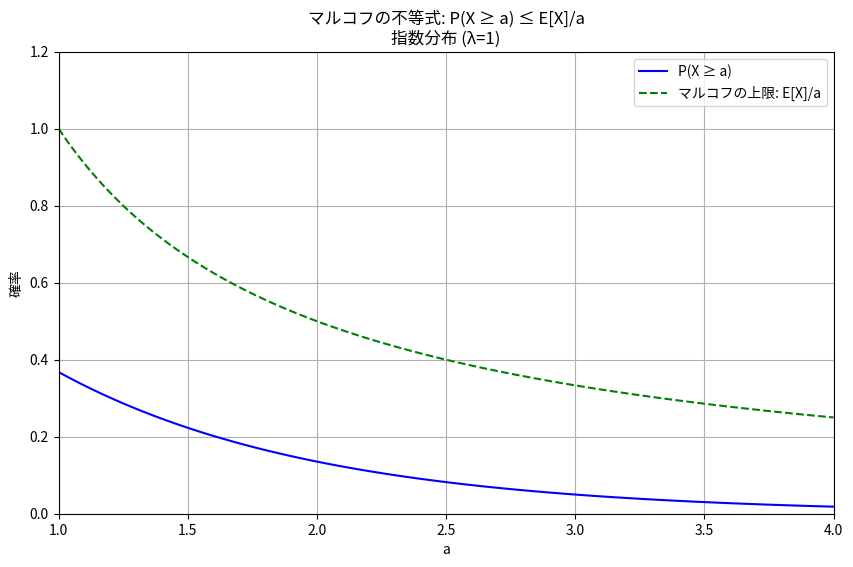

Plot saved as 'markov_exponential.png'
Generating plot for gamma...


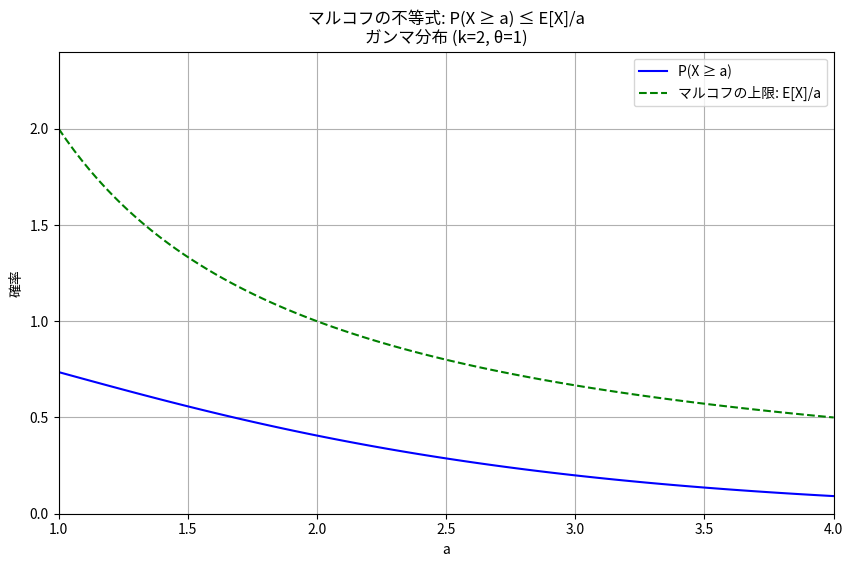

Plot saved as 'markov_gamma.png'
Generating plot for lognorm...


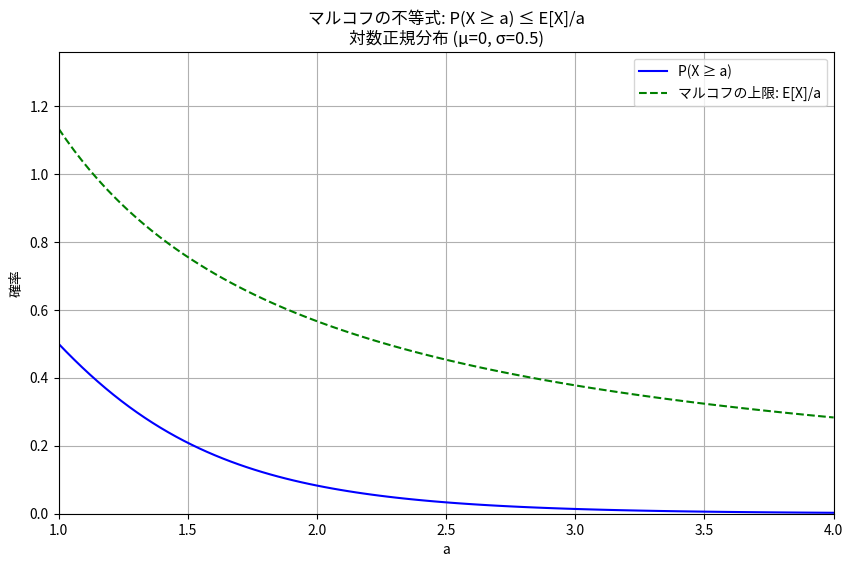

Plot saved as 'markov_lognorm.png'
Generating plot for beta...


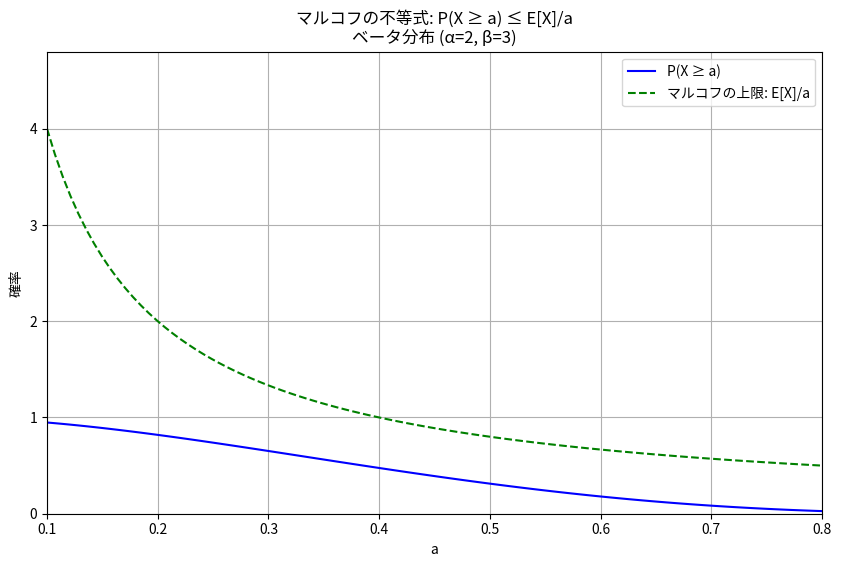

Plot saved as 'markov_beta.png'
Generating plot for chi2...


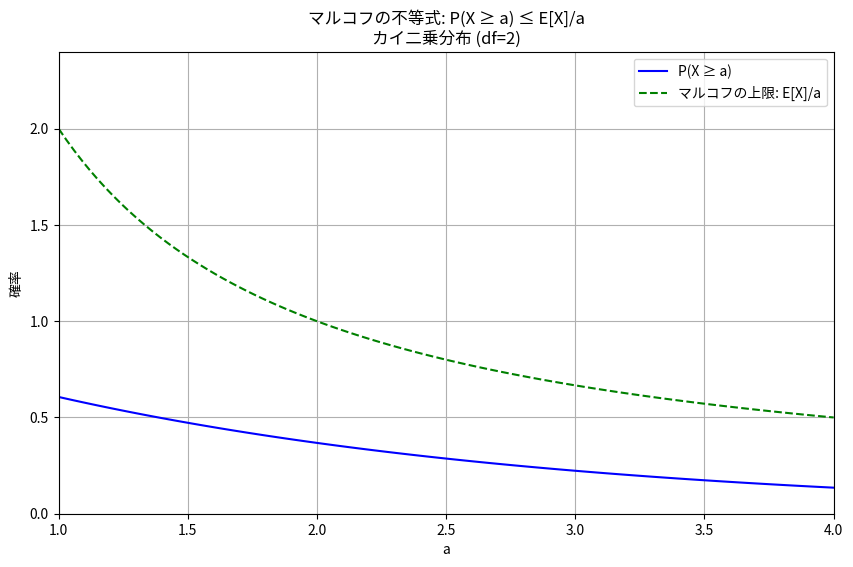

Plot saved as 'markov_chi2.png'
Generating plot for rayleigh...


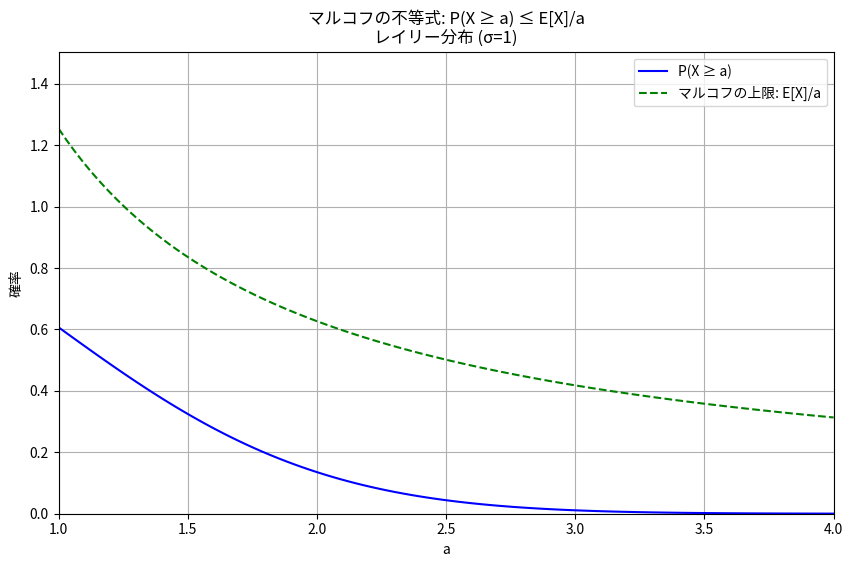

Plot saved as 'markov_rayleigh.png'
Generating plot for pareto...


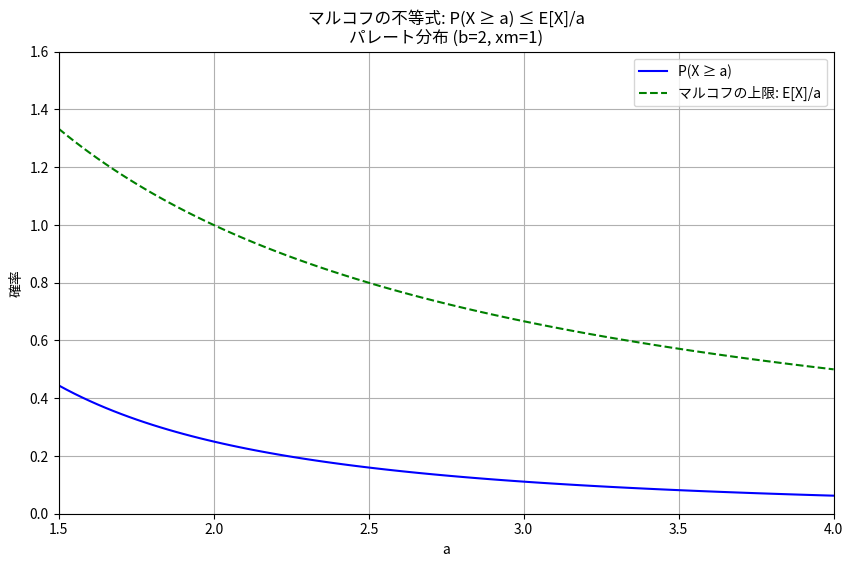

Plot saved as 'markov_pareto.png'
Generating plot for f...


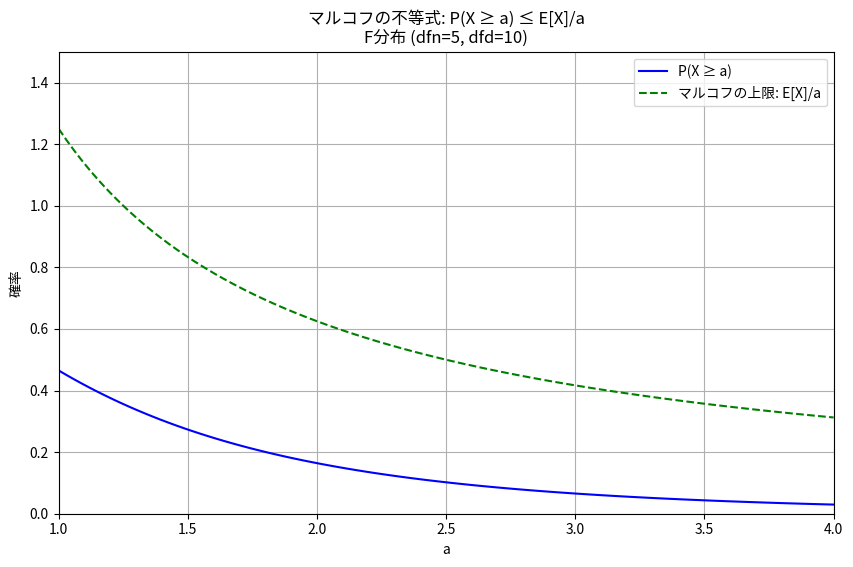

Plot saved as 'markov_f.png'
Generating plot for cauchy...


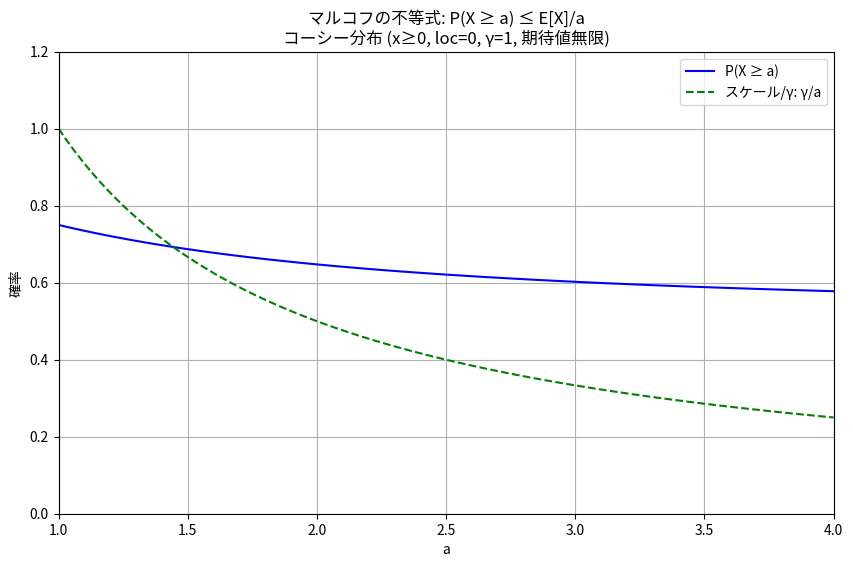

Plot saved as 'markov_cauchy.png'


In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from scipy.stats import expon, gamma, lognorm, weibull_min, beta, chi2, rayleigh, pareto, f, cauchy
import platform
import warnings

# Matplotlibのフォント警告を抑制
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# システムに応じたフォントを選択
def get_available_font():
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    system = platform.system()
    if system == "Windows":
        for font in ['MS Gothic', 'Yu Gothic', 'Meiryo']:
            if font in available_fonts:
                return font
    elif system == "Darwin":  # Mac
        for font in ['Hiragino Sans', 'AppleGothic', 'Noto Sans CJK JP']:
            if font in available_fonts:
                return font
    elif system == "Linux":
        for font in ['Noto Sans CJK JP', 'DejaVu Sans']:
            if font in available_fonts:
                return font
    return 'DejaVu Sans'

# フォントを設定
selected_font = get_available_font()
plt.rcParams['font.family'] = selected_font
print(f"Selected font: {selected_font}")

# 分布のリスト（名前、パラメータ、期待値、a範囲）
distributions = [
    {
        'name': 'exponential',
        'params': {'scale': 1},  # E[X] = scale = 1
        'mu': 1,
        'a_range': (1, 4),
        'cdf_func': lambda a, params: expon.cdf(a, scale=params['scale']),
        'dist_label': '指数分布 (λ=1)'
    },
    {
        'name': 'gamma',
        'params': {'k': 2, 'theta': 1},  # E[X] = k*theta = 2
        'mu': 2,
        'a_range': (1, 4),
        'cdf_func': lambda a, params: gamma.cdf(a, a=params['k'], scale=params['theta']),
        'dist_label': 'ガンマ分布 (k=2, θ=1)'
    },
    {
        'name': 'lognorm',
        'params': {'mu': 0, 'sigma': 0.5},  # E[X] = exp(mu + sigma^2/2) ≈ 1.284
        'mu': np.exp(0 + 0.5**2 / 2),
        'a_range': (1, 4),
        'cdf_func': lambda a, params: lognorm.cdf(a, s=params['sigma'], scale=np.exp(params['mu'])),
        'dist_label': '対数正規分布 (μ=0, σ=0.5)'
    },
    # {
    #     'name': 'weibull',
    #     'params': {'c': 2, 'scale': 1.128},  # E[X] = scale * Γ(1 + 1/c) ≈ 1
    #     'mu': 1.128 * gamma(1 + 1/2),
    #     'a_range': (1, 4),
    #     'cdf_func': lambda a, params: weibull_min.cdf(a, c=params['c'], scale=params['scale']),
    #     'dist_label': 'ワイブル分布 (c=2, scale=1.128)'
    # },
    {
        'name': 'beta',
        'params': {'a': 2, 'b': 3},  # E[X] = a/(a+b) = 0.4
        'mu': 2 / (2 + 3),
        'a_range': (0.1, 0.8),  # ベータは[0,1]に限定
        'cdf_func': lambda a, params: beta.cdf(a, a=params['a'], b=params['b']),
        'dist_label': 'ベータ分布 (α=2, β=3)'
    },
    {
        'name': 'chi2',
        'params': {'df': 2},  # E[X] = df = 2
        'mu': 2,
        'a_range': (1, 4),
        'cdf_func': lambda a, params: chi2.cdf(a, df=params['df']),
        'dist_label': 'カイ二乗分布 (df=2)'
    },
    {
        'name': 'rayleigh',
        'params': {'scale': 1},  # E[X] = scale * sqrt(π/2) ≈ 1.253
        'mu': 1 * np.sqrt(np.pi / 2),
        'a_range': (1, 4),
        'cdf_func': lambda a, params: rayleigh.cdf(a, scale=params['scale']),
        'dist_label': 'レイリー分布 (σ=1)'
    },
    {
        'name': 'pareto',
        'params': {'b': 2, 'scale': 1},  # E[X] = scale * b / (b-1) = 2
        'mu': 1 * 2 / (2 - 1),
        'a_range': (1.5, 4),  # x ≥ scale
        'cdf_func': lambda a, params: pareto.cdf(a, b=params['b'], scale=params['scale']),
        'dist_label': 'パレート分布 (b=2, xm=1)'
    },
    {
        'name': 'f',
        'params': {'dfn': 5, 'dfd': 10},  # E[X] = dfd / (dfd-2) ≈ 1.25
        'mu': 10 / (10 - 2),
        'a_range': (1, 4),
        'cdf_func': lambda a, params: f.cdf(a, dfn=params['dfn'], dfd=params['dfd']),
        'dist_label': 'F分布 (dfn=5, dfd=10)'
    },
    {
        'name': 'cauchy',
        'params': {'loc': 0, 'scale': 1},  # 期待値無限、中央値=loc
        'mu': None,  # マルコフ不等式非適用、γ=1で表示
        'a_range': (1, 4),
        'cdf_func': lambda a, params: cauchy.cdf(a, loc=params['loc'], scale=params['scale']) - cauchy.cdf(0, loc=params['loc'], scale=params['scale']),
        'dist_label': 'コーシー分布 (x≥0, loc=0, γ=1, 期待値無限)'
    }
]

# 各分布でグラフを生成
for dist in distributions:
    print(f"Generating plot for {dist['name']}...")

    # 分布のパラメータ
    params = dist['params']
    mu = dist['mu']
    a_min, a_max = dist['a_range']
    a_values = np.linspace(a_min, a_max, 100)  # aの値
    p_x_geq_a = [1 - dist['cdf_func'](a, params) for a in a_values]  # P(X ≥ a)

    # グラフの設定
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(a_values, p_x_geq_a, label='P(X ≥ a)', color='blue')
    
    # マルコフ上限
    if dist['name'] == 'cauchy':
        markov_bound = 1 / a_values  # スケール/γ
        ax.plot(a_values, markov_bound, label='スケール/γ: γ/a', color='green', linestyle='--')
    else:
        markov_bound = mu / a_values
        ax.plot(a_values, markov_bound, label=f'マルコフの上限: E[X]/a', color='green', linestyle='--')
    
    ax.grid(True)
    ax.set_xlabel('a')
    ax.set_ylabel('確率')
    ax.set_title(f'マルコフの不等式: P(X ≥ a) ≤ E[X]/a\n{dist["dist_label"]}')
    ax.set_ylim(0, max(max(p_x_geq_a), max(markov_bound)) * 1.2)
    ax.set_xlim(a_min, a_max)
    ax.legend()

    # PNGとして保存
    png_filename = f'markov_{dist["name"]}.png'
    plt.savefig(png_filename, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    print(f"Plot saved as '{png_filename}'")